In [36]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import sparse_categorical_crossentropy
import numpy as np

In [37]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
176084,She was ready to give him back all his money.,Elle était prête à lui rendre tout son argent.,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
181635,Tom would never say something like that to Mary.,Tom ne dirait jamais quelque chose comme ça à ...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
181330,Something tells me that you're hiding something.,Mon petit doigt me dit que tu caches quelque c...,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
72720,I'm a little bit jealous.,Je suis un tantinet jaloux.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
128444,Do you ever study in the library?,Est-ce que vous étudiez à la bibliothèque des ...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [38]:
lines = lines[['eng', 'fra']][:33000] # 3.3만개 샘플 사용
lines.sample(5)

,eng,fra
27274,We're married now.,Nous sommes désormais mariés.
13739,He plays soccer.,Il joue au football.
11944,They struggled.,Elles ont morflé.
30553,I'm at my parents'.,Je suis chez mes parents.
31447,Now I'm in trouble.,"Désormais, j'ai des ennuis."


In [39]:
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 33000


,eng,fra
16239,Tom is involved.,Tom est impliqué.
29296,He's pushing fifty.,Il frôle les cinquante ans.
9660,Be nice to her.,Sois gentil avec elle.
210,Come in.,Entrez !
32205,They want to leave.,Ils veulent s'en aller.


In [40]:
lines.fra

0                                      Va !
1                                   Marche.
2                                En route !
3                                   Bouge !
4                                   Salut !
                        ...                
32995    Nous avons toutes beaucoup pleuré.
32996                Nous avions tous faim.
32997         Nous avons aussi trouvé ceci.
32998         Nous sommes des gens occupés.
32999         Nous regardons la télévision.
Name: fra, Length: 33000, dtype: object

## 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

In [41]:
import re
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-zA-Z?.!,¿']+", " ", sentence) 
    sentence = sentence.strip() 
    return sentence

import re
def preprocess_sentence2(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-zA-Z?.!,¿']+", " ", sentence) 
    sentence = sentence.strip()
    sentence = "<sos> " + sentence + " <eos>"
    return sentence


In [42]:
line = []

for a in lines.fra:
    preprocessed_sentence = preprocess_sentence2(a)
    line.append(preprocessed_sentence)
line[:10]

['<sos> va ! <eos>',
 '<sos> marche . <eos>',
 '<sos> en route ! <eos>',
 '<sos> bouge ! <eos>',
 '<sos> salut ! <eos>',
 '<sos> salut . <eos>',
 '<sos> cours ! <eos>',
 '<sos> courez ! <eos>',
 '<sos> prenez vos jambes vos cous ! <eos>',
 '<sos> file ! <eos>']

In [43]:
line2 = []

for a in lines.eng:
    preprocessed_sentence = preprocess_sentence(a)
    line2.append(preprocessed_sentence)
line2[:10]

['go .',
 'go .',
 'go .',
 'go .',
 'hi .',
 'hi .',
 'run !',
 'run !',
 'run !',
 'run !']

## 케라스의 토크나이저로 텍스트를 숫자로 바꾸기

In [44]:
eng_tokenizer = Tokenizer(char_level=False, filters = '')   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(line2)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(line2)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:10]

[[25, 1],
 [25, 1],
 [25, 1],
 [25, 1],
 [782, 1],
 [782, 1],
 [207, 20],
 [207, 20],
 [207, 20],
 [207, 20]]

In [45]:
fra_tokenizer = Tokenizer(char_level=False, filters = '')  #char_level=False, # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(line)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(line)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:10]

[[1, 70, 7, 2],
 [1, 384, 3, 2],
 [1, 26, 541, 7, 2],
 [1, 754, 7, 2],
 [1, 789, 7, 2],
 [1, 789, 3, 2],
 [1, 694, 7, 2],
 [1, 1953, 7, 2],
 [1, 194, 282, 1097, 282, 2727, 7, 2],
 [1, 1541, 7, 2]]

In [46]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4771
프랑스어 단어장의 크기 : 7972


In [47]:
# 훈련 후 결과 비교할때 사용
src_to_index= eng_tokenizer.word_index
index_to_src= eng_tokenizer.index_word
# 훈련 후 예측 과정에서 사용
# 훈련 후 결과 비교할 때 사용
tar_to_index= fra_tokenizer.word_index
index_to_tar= fra_tokenizer.index_word


In [48]:
max_eng_seq_len = max([len(line2) for line2 in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


## 디코더의 문장에 시작 토큰과 종료 토큰을 넣고, 종료 토큰, 시작 토큰 제거

In [49]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index['<eos>'] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index['<sos>'] ] for line in target_text]

In [50]:
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_target[:3])

[[25, 1], [25, 1], [25, 1]]
[[1, 70, 7], [1, 384, 3], [1, 26, 541, 7]]
[[70, 7, 2], [384, 3, 2], [26, 541, 7, 2]]


In [51]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 16)
프랑스어 출력데이터의 크기(shape) : (33000, 16)


In [52]:
print(encoder_input[0])

[25  1  0  0  0  0  0  0]


In [71]:
encoder_input[0]

array([ 80,   4,  45, 944,   1,   0,   0,   0], dtype=int32)

셔플을 줘서 섞었다.

In [54]:
import numpy as np
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[25637  7082 10396 ... 25940 27460 26414]


In [55]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [56]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (30000, 8)
훈련 target 데이터의 크기 : (30000, 16)
훈련 target 레이블의 크기 : (30000, 16)
테스트 source 데이터의 크기 : (3000, 8)
테스트 target 데이터의 크기 : (3000, 16)
테스트 target 레이블의 크기 : (3000, 16)


## 임베딩 층(Embedding layer) 사용하기

In [57]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [58]:
latent_dim = 64

In [59]:
# 인코더
# 입력 텐서 생성.
encoder_inputs = Input(shape=(None,))
# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_emb = Embedding(eng_vocab_size, latent_dim)(encoder_inputs)
encoder_masking =Masking(mask_value=0.0)(encoder_emb)
encoder_lstm = LSTM(latent_dim, return_state = True)
# 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_masking)
# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

In [60]:
# 디코더
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None,))
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_emb_layer = Embedding(fra_vocab_size, latent_dim)
decoder_emb = decoder_emb_layer(decoder_inputs)
decoder_masking =Masking(mask_value=0.0)(decoder_emb)

decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state=True)
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_masking, initial_state = encoder_states)

In [61]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

## 모델 구현

In [62]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     305344      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     510208      input_6[0][0]                    
____________________________________________________________________________________________

In [63]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 14s 35ms/step - loss: 2.7631 - acc: 0.6482 - val_loss: 1.7784 - val_acc: 0.7409
Epoch 2/50
235/235 [==============================] - 6s 25ms/step - loss: 1.6406 - acc: 0.7490 - val_loss: 1.5855 - val_acc: 0.7548
Epoch 3/50
235/235 [==============================] - 6s 26ms/step - loss: 1.5078 - acc: 0.7609 - val_loss: 1.4815 - val_acc: 0.7676
Epoch 4/50
235/235 [==============================] - 6s 26ms/step - loss: 1.3956 - acc: 0.7787 - val_loss: 1.3853 - val_acc: 0.7861
Epoch 5/50
235/235 [==============================] - 6s 26ms/step - loss: 1.3048 - acc: 0.7925 - val_loss: 1.3151 - val_acc: 0.7960
Epoch 6/50
235/235 [==============================] - 6s 25ms/step - loss: 1.2379 - acc: 0.8027 - val_loss: 1.2647 - val_acc: 0.8040
Epoch 7/50
235/235 [==============================] - 6s 25ms/step - loss: 1.1867 - acc: 0.8099 - val_loss: 1.2179 - val_acc: 0.8100
Epoch 8/50
235/235 [==============================] - 6s 25ms/step -

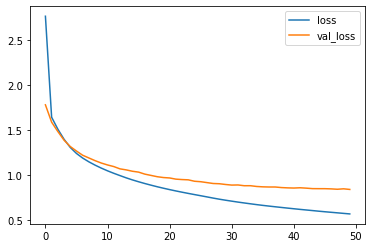

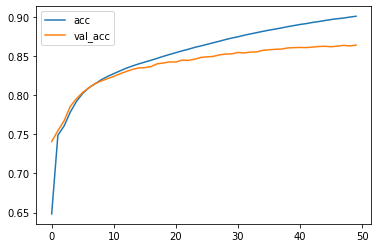

In [64]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
history_df['loss'].plot()
history_df['val_loss'].plot()
plt.legend()
plt.show()


history_df = pd.DataFrame(history.history)
history_df['acc'].plot()
history_df['val_acc'].plot()
plt.legend()
plt.show()

## 모델 평가하기

In [65]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)
# 디코더
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_inputs = [decoder_state_input_h,decoder_state_input_c]

dec_emb2 = decoder_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state= decoder_state_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [66]:
# 디코더 정의
decoder_model = Model([decoder_inputs]+decoder_state_inputs,[decoder_outputs2]+decoder_states2)

In [67]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <sos>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = tar_to_index['<sos>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [68]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp=temp+index_to_src[i]+ ' '
    return temp
# 변역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i != tar_to_index['<sos>']) and i != tar_to_index['<eos>']):
            temp=temp+index_to_tar[i]+ ' '
    return temp

In [69]:
import numpy as np
for seq_index in  [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_train[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_train[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:-5])

-----------------------------------
입력 문장: please try again . 
정답 문장: veuillez essayer de nouveau . 
번역기가 번역한 문장:  essaie de ce no
-----------------------------------
입력 문장: ghosts exist . 
정답 문장: les fant mes existent . 
번역기가 번역한 문장:  les enfant . 
-----------------------------------
입력 문장: fry an egg for me . 
정답 문장: cuis moi un uf . 
번역기가 번역한 문장:  laissez moi un 
-----------------------------------
입력 문장: go away . 
정답 문장: disparais ! 
번역기가 번역한 문장:  d gage ! 
-----------------------------------
입력 문장: it's instinct . 
정답 문장: c'est l'instinct . 
번역기가 번역한 문장:  c'est conti


In [70]:
for seq_index in  [1, 250, 431, 105,322]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:-5])

-----------------------------------
입력 문장: tell us more . 
정답 문장: dis nous en plus . 
번역기가 번역한 문장:  dites nous en
-----------------------------------
입력 문장: get out of my bed . 
정답 문장: d gage de mon lit ! 
번역기가 번역한 문장:  sortez de mo
-----------------------------------
입력 문장: she is prudish . 
정답 문장: elle est prude . 
번역기가 번역한 문장:  elle est en 
-----------------------------------
입력 문장: i miss my wife . 
정답 문장: ma femme me manque . 
번역기가 번역한 문장:  ma femme me m
-----------------------------------
입력 문장: i didn't buy them . 
정답 문장: je n'ai pas proc d leur acquisition . 
번역기가 번역한 문장:  je ne les a


-----------------------------------
입력 문장: tell us more . -> 자세히 말해 주세요.

정답 문장: dis nous en plus . -> 자세히 말해 주세요.

번역기가 번역한 문장:  dites nous en -> 얘기해 주세요.

-----------------------------------
입력 문장: get out of my bed . -> 내 침대에서 일어나다

정답 문장: d gage de mon lit ! -> 내 침대에서 일어나다

번역기가 번역한 문장:  sortez de mo -> 탈피하다

-----------------------------------
입력 문장: she is prudish . -> 그녀는 교활하다.

정답 문장: elle est prude . -> 그녀는 교활하다.

번역기가 번역한 문장:  elle est en -> 그녀는 안에있다.

-----------------------------------
입력 문장: i miss my wife . -> 내 아내가 그리워. 

정답 문장: ma femme me manque . -> 내 아내가 그리워.

번역기가 번역한 문장:  ma femme me m -> 내 아내는 날 좋아해.

-----------------------------------
입력 문장: i didn't buy them . -> 나는 그것들을 사지 않았다.

정답 문장: je n'ai pas proc d leur acquisition . -> 나는 그것들을 사지 않았다.

번역기가 번역한 문장:  je ne les a -> 난 그것들이 없다.

## 회고
- 어려웠던 점 : encoder와 decoder을 구분해서 model을 구현하는게 어려웠다.
- 알아낸 점 및 모호한 점 : 마지막 출력 시킬때, encoder_input과 decoder_input을 잘 구분해서 적어야하는 것을 알게 되었다.
- 노력한 점 : val_loss가 우하향하는 모습을 보도록 그래프를 그렸다. shaffle을 해서 두 loss 그래프 사이의 차이가 줄어들게 했다.
- 자기다짐 : 번역기를 또 한글로 바꾸는 점이 힘들었지만, 완성도 있는 번역기를 확인 할 수 있어서 좋았다.